![](https://cdn.theatlantic.com/thumbor/npZfAjSjxXVdQoYrvTSm6th1GHY=/584x0:2917x2333/500x500/media/img/mt/2016/01/RTX22DCB/original.jpg)

Welcome to this notebook where I try to segment pictures of various items on a food tray using UNets with an architecture of ResNet34. This is my first time doing segmentation in computer vision so do correct me and give any suggestions in the comments :)

An [article on Medium](https://towardsdatascience.com/fastai-image-segmentation-eacad8543f6f) about the same helped me quite a lot, so do check it out.

# Importing the Libraries:

In [1]:
!git clone https://github.com/Tommy-Ngx/ColabRerun

Cloning into 'ColabRerun'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 23 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [ ]:
!unzip /content/ColabRerun/TrayFood.zip

In [3]:
#Importing the FastAI libraries:

import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

# Data Prep:

Down here I am preparing the data to be trained and fastAI's library is quite simplistic to use like, anyone can train a UNet using it and do segmentation.

In [4]:
# Defining the path where my JPG images are stored:
trainpath = "/content/TrayDataset/TrayDataset/XTrain/"

# Defining the path where the mask PNG images of the images mentioned above are stored:
trainlabel = "/content/TrayDataset/TrayDataset/yTrain/"

# Taking out the JPG filenames out of the training data folder:
fnames = get_image_files(trainpath)

Below is a function which defines how our data module will find the labels to the images it learns segmentation with. Lambda in layman's language here refers to defining a function with input x.

*trainlabel* refers to the folder path where all the labels are stored.

*x.stem* refers to the image's name while, .PNG is concatenated with it because the mask is not a JPG but a PNG. 

In [5]:
get_y = lambda x: trainlabel + x.stem + '.png' 

Lets take a look at the images and their respective masks:

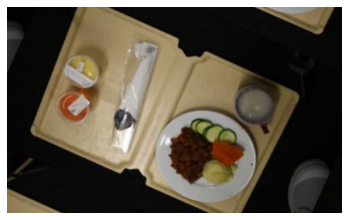

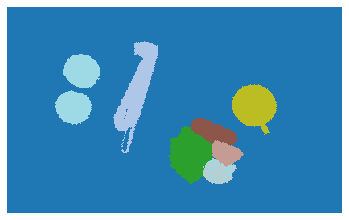

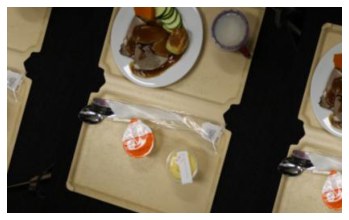

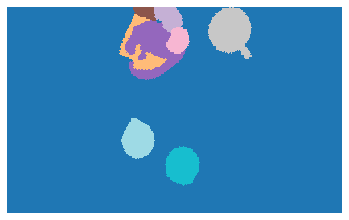

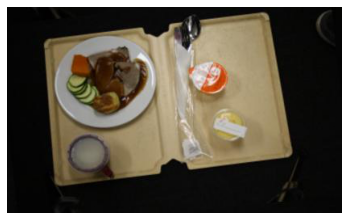

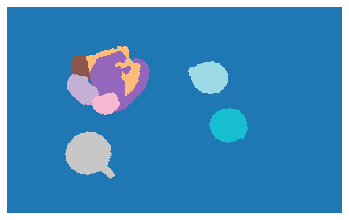

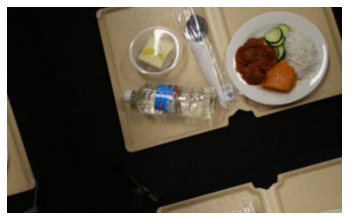

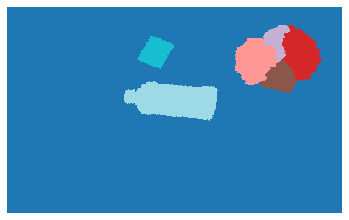

In [6]:
for i in range(0,4):
    img = open_image(fnames[i])
    mask = open_mask(get_y(fnames[i]))
    img.show(figsize=(6,6)), mask.show(figsize=(6,6), alpha=1)

Noting important measures:

In [7]:
src_shape = np.array(mask.shape[1:])
size = src_shape // 2
bs = 4

The classes are stored in a csv so taking a look at it:

In [8]:
classescsv = pd.read_csv("/content/classes.csv")

classescsv.head()

,_id,_class,_name
0,0,background,background
1,1,tray,tray
2,2,cutlery,cutlery
3,3,form,form
4,4,straw,straw


I will now seperate out the _class since it contains the classes and turn it into a list:

In [9]:
classes = list(classescsv['_class'])

Finally defining the data our model will run on:

In [10]:
src = (SegmentationItemList
       .from_folder(trainpath)
       .split_by_rand_pct(.2)
       .label_from_func(get_y, classes=classes))

In [11]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


Taking a look at an image with its mask:

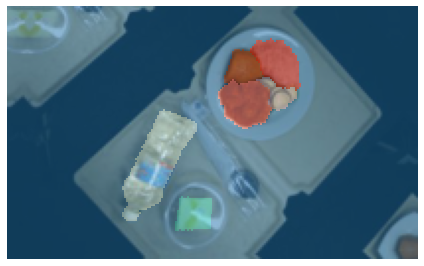

In [12]:
data.show_batch(1, figsize=(6,6))

Defining and downloading the UNet:

In [13]:
learner = unet_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# Training and Predicting:

Training the data:

In [14]:
learner.fit_one_cycle(12)

epoch,train_loss,valid_loss,time
0,0.403457,0.385805,01:25
1,0.272149,0.281864,01:19
2,0.320767,0.230836,01:18
3,0.197161,0.143159,01:18
4,0.170539,0.110509,01:17
5,0.109361,0.087778,01:18
6,0.102378,0.078740,01:18
7,0.095130,0.075152,01:18
8,0.065280,0.052455,01:18
9,0.059131,0.047305,01:19


Since the both the losses seem small enough, lets predict:

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


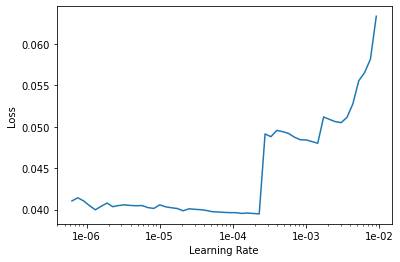

In [15]:
learner.save('/content/trayseg.pth') # save model

learner.lr_find() # find learning rate
learner.recorder.plot() # plot learning rate graph

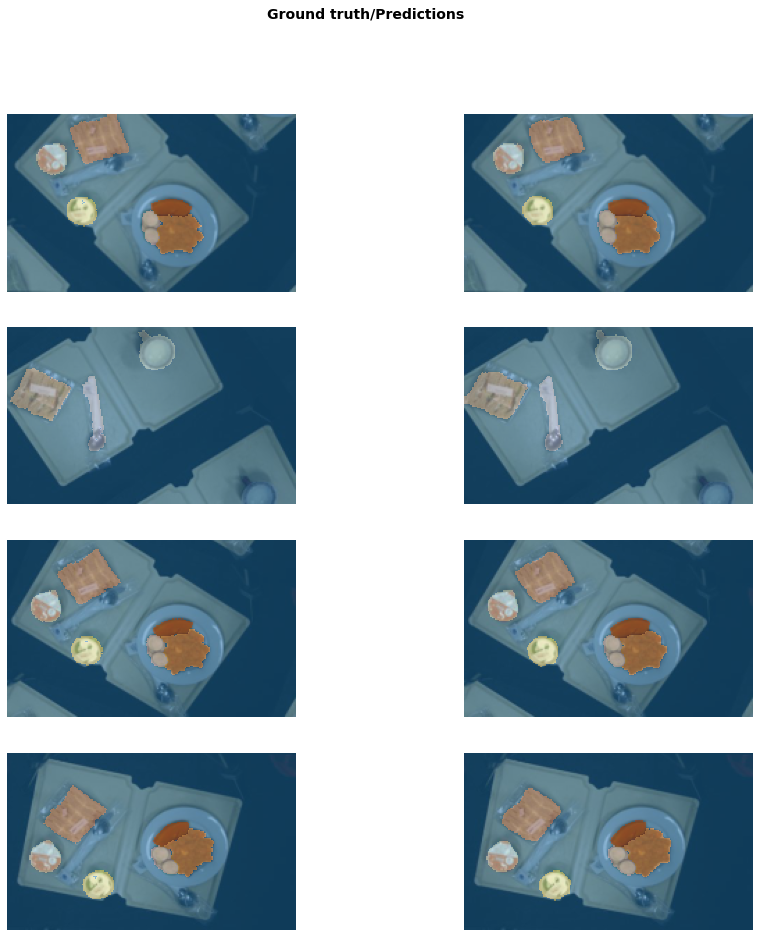

In [17]:
learner.show_results(figsize=(15,15))

On the left is the actual images while on the left is the predictions! They look almost identical and thereby here I conclude this notebook.

If you liked this notebook, an upvote would be of tremendous help as I trot forward with my infatuation with Deep Learning :)

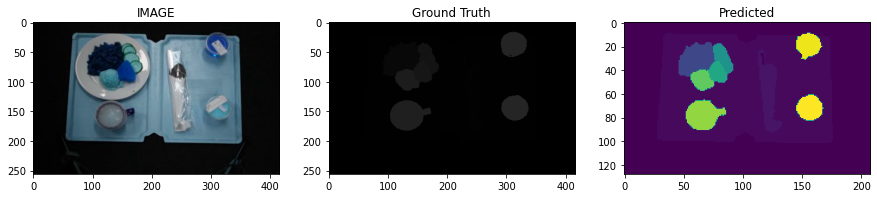

In [122]:
img = open_image('/content/TrayDataset/TrayDataset/XTest/2002a.jpg')
img2 = cv2.imread("/content/TrayDataset/TrayDataset/XTest/2002a.jpg")
prediction = learner.predict(img)
prediction[0].save('temp1.png')
#prediction2  = open_mask("temp1.png")
ground_truth_mask = cv2.imread("/content/TrayDataset/TrayDataset/yTest/2002a.png",cv2.COLOR_RGB2BGR)
ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_BGR2RGB)
prediction2       = cv2.imread("temp1.png",cv2.COLOR_RGB2BGR)


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("IMAGE")
ax1.imshow(img2)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Ground Truth")
ax2.imshow(ground_truth_mask)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title("Predicted")
ax3.imshow(prediction2)

In [118]:
print(ground_truth_mask.shape)

(256, 416, 3)


In [47]:
best_model = torch.load('/content/trayseg.pth.pth')
